In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
cwd = os.getcwd()

NOTEBOOK_DIR = os.path.dirname(cwd)
ROOT = os.path.dirname(os.path.dirname(os.path.dirname(NOTEBOOK_DIR)))

FIGURES_DIR = os.path.join(ROOT, 'figures/abc_parameterizations/debug_ipllr_renorm')
CONFIG_PATH = os.path.join(ROOT, 'pytorch/configs/abc_parameterizations', 'fc_ipllr_mnist.yaml')

In [3]:
import sys
sys.path.append(ROOT)

In [4]:
import os
from copy import deepcopy
import torch
import math
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, Subset, DataLoader
import torch.nn.functional as F

from utils.tools import read_yaml, set_random_seeds
from pytorch.configs.base import BaseConfig
from pytorch.configs.model import ModelConfig
from pytorch.models.abc_params.fully_connected.ipllr import FcIPLLR
from pytorch.models.abc_params.fully_connected.muP import FCmuP
from pytorch.models.abc_params.fully_connected.ntk import FCNTK
from pytorch.models.abc_params.fully_connected.standard_fc_ip import StandardFCIP
from utils.data.mnist import load_data
from utils.abc_params.debug_ipllr import *
from utils.plot.abc_parameterizations.debug_ipllr import *

### Load basic configuration and define variables 

In [5]:
N_TRIALS = 5
SEED = 30
L = 6
width = 1024
n_warmup_steps = 1
batch_size = 512
base_lr = 0.1
n_steps = 100
renorm_first = False
scale_first_lr = False

set_random_seeds(SEED)  # set random seed for reproducibility
config_dict = read_yaml(CONFIG_PATH)

In [6]:
config_dict = read_yaml(CONFIG_PATH)

input_size = config_dict['architecture']['input_size']

config_dict['architecture']['width'] = width
config_dict['architecture']['n_layers'] = L + 1
config_dict['optimizer']['params']['lr'] = base_lr
config_dict['scheduler'] = {'name': 'warmup_switch',
                            'params': {'n_warmup_steps': n_warmup_steps,
                                       'calibrate_base_lr': True,
                                       'default_calibration': False}}
        
base_model_config = ModelConfig(config_dict)

### Load data & define models

In [7]:
training_dataset, test_dataset = load_data(download=False, flatten=True)
train_data_loader = DataLoader(training_dataset, shuffle=True, batch_size=batch_size)
test_batches = list(DataLoader(test_dataset, shuffle=False, batch_size=batch_size))
batches = list(train_data_loader)
eval_batch = test_batches[0]

In [8]:
base_model_config.scheduler = None
muPs = [FCmuP(base_model_config) for _ in range(N_TRIALS)]
muPs_renorm = [FCmuP(base_model_config) for _ in range(N_TRIALS)]
muPs_renorm_scale_lr = [FCmuP(base_model_config) for _ in range(N_TRIALS)]

for muP in muPs_renorm_scale_lr:
    for i, param_group in enumerate(muP.optimizer.param_groups):
        if i == 0:
            param_group['lr'] = param_group['lr'] * (muP.d + 1)

In [9]:
for i in range(N_TRIALS):
    muPs_renorm[i].copy_initial_params_from_model(muPs[i])
    muPs_renorm_scale_lr[i].copy_initial_params_from_model(muPs[i])
    
    muPs_renorm[i].initialize_params()
    muPs_renorm_scale_lr[i].initialize_params()

In [10]:
muPs_0 = [deepcopy(muP) for muP in muPs]
muPs_renorm_0 = [deepcopy(muP) for muP in muPs_renorm]
muPs_renorm_scale_lr_0 = [deepcopy(muP) for muP in muPs_renorm_scale_lr]

In [11]:
results = {'muP': [], 'muP_renorm': [], 'muP_renorm_scale_lr': []}

results['muP'] = [collect_training_losses(muPs[i], batches, n_steps, normalize_first=False) 
                  for i in range(N_TRIALS)]

results['muP_renorm'] = [collect_training_losses(muPs_renorm[i], batches, n_steps, normalize_first=True)
                         for i in range(N_TRIALS)]

results['muP_renorm_scale_lr'] = [collect_training_losses(muPs_renorm_scale_lr[i], batches, n_steps, 
                                                          normalize_first=True) 
                                  for i in range(N_TRIALS)]

# Training

In [12]:
mode = 'training'

In [13]:
losses = dict()
for key, res in results.items():
    losses[key] = [r[0] for r in res]
    
chis = dict()
for key, res in results.items():
    chis[key] = [r[1] for r in res]

## Losses and derivatives

In [16]:
losses['muP'][0][-1]

0.24190427362918854

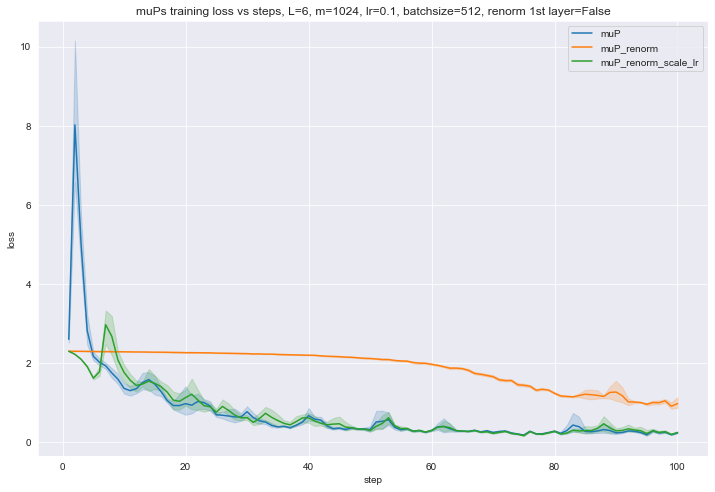

In [17]:
key = 'loss'
plt.figure(figsize=(12, 8))
plot_losses_models(losses, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, mode=mode, 
                   normalize_first=renorm_first, marker=None, name='muP')
plt.savefig(
    os.path.join(FIGURES_DIR, 'muPs_{}_{}_L={}_m={}_lr={}_bs={}.png'.\
                 format(mode, key, L, width, base_lr, batch_size, renorm_first, scale_first_lr)))
plt.show()

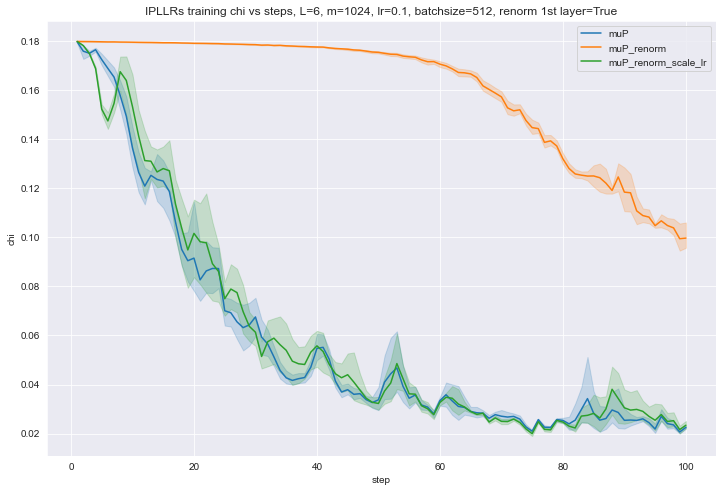

In [18]:
key = 'chi'
plt.figure(figsize=(12, 8))
plot_losses_models(chis, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, mode=mode, marker=None, 
                   name='IPLLR')
plt.savefig(os.path.join(FIGURES_DIR, 'muPs_{}_{}_L={}_m={}_lr={}_bs={}.png'.format(mode, key, L, width, base_lr, 
                                                                               batch_size)))
plt.show()